# Figure 5 Integrated power 40-1040 kHz
In this notebook we demonstrate how to calculate and plot the integrated power of a time series for the frequency range 40-1040 kHz

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import LogLocator
import matplotlib.transforms as transforms
import numpy as np
import vaex as vx
import pandas as pd
from tqdm import tqdm
from Wind_Waves.integration_tools import integrate, linear_segments
from Wind_Waves.integration_tools import create_sweeps, create_spins
from Wind_Waves.reading_tools import raw2csv
from Wind_Waves.plotting_tools import spectragram


# Creates a tqdm-based progressbar
def progressbar(iterable, max_value=None, **kwargs):
    """
    Wraps tqdm to keep the same API as the old `progressbar` package.

    Parameters
    ----------
    iterable : iterable
        The iterable to wrap.
    max_value : int, optional
        The total number of iterations (mapped to tqdm's `total` argument).
    **kwargs :
        Additional keyword arguments passed to tqdm.
    """
    if max_value is not None:
        return tqdm(iterable, total=max_value, **kwargs)
    else:
        return tqdm(iterable, **kwargs)

## Calculate Integrated Power
### Select Frequency Range

In [19]:
fmin= 40
fmax= 1040

### Select Event Time Ranges

In [20]:
events= [['Solar_Burst', np.datetime64('2004-02-06T03:00'), np.datetime64('2004-02-06T05:00')],
          ['AKR_Burst', np.datetime64('2001-02-21T02:00'), np.datetime64('2001-02-21T05:00')],
          ['LFEs', np.datetime64('2001-02-28 17:00'), np.datetime64('2001-02-28 20:00')]]

### Calculate Integrated Power for Each Event
- Gap filling is applied using the spectragram function
- Linear functions calculated to create continuos functional form of flux in the frequency dimension at each time step
- Linear functions integrated over the chosen frequency range
- Loop over the events

In [21]:
for name, start, end in progressbar(events, max_value=len(events)):
    start-= np.timedelta64(183, 's')
    end+= np.timedelta64(183, 's')


    days = start+ np.arange((end.astype('datetime64[D]')-start.astype('datetime64[D]')).astype('timedelta64[D]')+1)
    raw= vx.open(list((np.unique([raw2csv(date, '../../Example_Data/raw_rad1/', '../../Example_Data/raw_rad1/') for date in (days)]))))

    raw.drop('SWEEP', inplace=True)
    raw= raw.to_pandas_df()
    create_sweeps(raw, time='Date_UTC')
    create_spins(raw, spin='SPIN')
    raw= vx.from_pandas(raw)
    # No gap filling


    t_, f_, values= spectragram(raw, groupby='SWEEP', frequency='FREQ', datetime='Date_UTC', flux='VZPAL_1au',
                        start=start, end=end, gap_filling='ignore')
    f_= np.sort(raw.FREQ.unique(selection=(raw.Date_UTC>=start)&(raw.Date_UTC<=end)))
    t_= t_[:-1]+np.diff(t_)/2

    t, f= np.meshgrid(t_, f_)



    df= pd.DataFrame({'AMPL_Z': values.flatten(),  'datetime_ut':t.flatten(), 'FREQ':f.flatten()})
    df.dropna(inplace=True)
    create_sweeps(df)
    lin_df= linear_segments(df, time='datetime_ut', frequency='FREQ', flux='AMPL_Z', sweep='SWEEP', preserve_cols=[])

    int_df= integrate(lin_df, flimits=(fmin, fmax))
    # With gap filling

    t_, f_, values= spectragram(raw, groupby='SPIN', frequency='FREQ', datetime='DATETIME_Z', flux='VZPAL_1au',
                        start=start, end=end, gap_filling='fill')

    t_= t_[:-1]+np.diff(t_)/2
    f_= f_[:-1]+np.diff(f_)/2

    t, f= np.meshgrid(t_, f_)
    raw_df= raw[['DATETIME_Z', 'SPIN', ]].to_pandas_df()
    ranges = raw_df.groupby("SPIN").agg(
        t1=("DATETIME_Z", "min"),
        t2=("DATETIME_Z", "max")
    ).reset_index()

    raw_df = raw_df.sort_values("DATETIME_Z")

    ranges_sorted = ranges.sort_values("t1")
    ranges_sorted['t']= ranges_sorted[['t1', 't2']].mean(axis=1)



    df= pd.DataFrame({'AMPL_Z': values.flatten(),  'DATETIME_Z':t.flatten(), 'FREQ':f.flatten()}).sort_values("DATETIME_Z")

    df = pd.merge_asof(
        df,
        ranges_sorted,
        left_on="DATETIME_Z",
        right_on="t1",
        direction="backward"
    )
    df.loc[df["DATETIME_Z"] > df["t2"], "SPIN"] = None

    lin_df= linear_segments(df, time='DATETIME_Z', frequency='FREQ', flux='AMPL_Z', sweep='SPIN', preserve_cols=[])

    int_df2= integrate(lin_df, flimits=(fmin, fmax), sweep='SPIN')





    raw.select((raw['Date_UTC']>=start)&(raw['Date_UTC']<=end))
    sweep_start, sweep_end= raw['SWEEP'].min(selection=True)-1, raw['SWEEP'].max(selection=True)+1
    raw.select((raw['SWEEP']>=sweep_start+1)&(raw['SWEEP']<=sweep_end-1))
    raw= raw.to_pandas_df(selection=True)
    raw.drop(columns=['SWEEP'], inplace=True)
    create_sweeps(raw, time='Date_UTC')
    create_spins(raw, spin='SPIN')


    time= raw.groupby('SWEEP').DATETIME_Z.min()+ (raw.groupby('SWEEP').DATETIME_Z.max()-raw.groupby('SWEEP').DATETIME_Z.min())/2
    sweeps= raw.groupby('SWEEP').SWEEP.min().values
    mapper= {sweep:time for sweep, time in zip(sweeps, time)}
    int_df['Date_UTC']= int_df.SWEEP.map(mapper)
    time= df.dropna(subset=['SPIN']).t.values
    spins= df.dropna(subset=['SPIN']).SPIN.values
    mapper= {sweep:time for sweep, time in zip(spins, time)}
    int_df2['Date_UTC']= int_df2.SPIN.map(mapper)
    int_df.to_csv(f'../../Example_Data/Integrated_Power_{name}_gappy.csv')
    int_df2.to_csv(f'../../Example_Data/Integrated_Power_{name}_filled.csv')

100%|██████████| 3/3 [01:35<00:00, 31.70s/it]


## Plot Integrated Power

In [22]:
def _format_timedelta(delta):
    """Return a short human-readable label for a numpy timedelta64."""
    total_seconds = delta / np.timedelta64(1, 's')
    if total_seconds % 3600 == 0:
        hours = int(total_seconds // 3600)
        return f"{hours} hr" if hours == 1 else f"{hours} hrs"
    if total_seconds % 60 == 0:
        minutes = int(total_seconds // 60)
        return f"{minutes} min"
    return f"{int(total_seconds)} s"


def add_time_whisker(ax, start_time, width, label=None, y_offset=-0.18, cap_frac=0.025, color='white', lw=4):
    """
    Draw a horizontal whisker scale bar with end caps to show a time width.

    Parameters
    ----------
    ax : matplotlib Axes
        Target axes.
    center_time : datetime64
        Where the whisker is centered on the x-axis.
    width : numpy.timedelta64
        Total width of the whisker.
    label : str, optional
        Text placed below the whisker. If None, a label is inferred from `width`.
    y_offset : float
        Y location in axis coordinates (0 is bottom of plot).
    cap_frac : float
        Half-height of each end cap in axis coordinates.
    color : str
        Line/text color.
    lw : int or float
        Line width.
    """
    half_width = width / 2
    # start_time = center_time - half_width
    end_time = start_time + width
    center_time = start_time + half_width

    label = label or _format_timedelta(width)

    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)

    # Main whisker line
    ax.plot([start_time, end_time], [y_offset, y_offset],
            color=color, lw=lw, transform=trans, clip_on=False)
    # End caps
    ax.plot([start_time, start_time], [y_offset - cap_frac, y_offset + cap_frac],
            color=color, lw=lw, transform=trans, clip_on=False)
    ax.plot([end_time, end_time], [y_offset - cap_frac, y_offset + cap_frac],
            color=color, lw=lw, transform=trans, clip_on=False)

    ax.text(center_time, y_offset - cap_frac * 1.4, label,
            transform=trans, ha='center', va='top', color=color, fontsize=26)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

### Create Figure

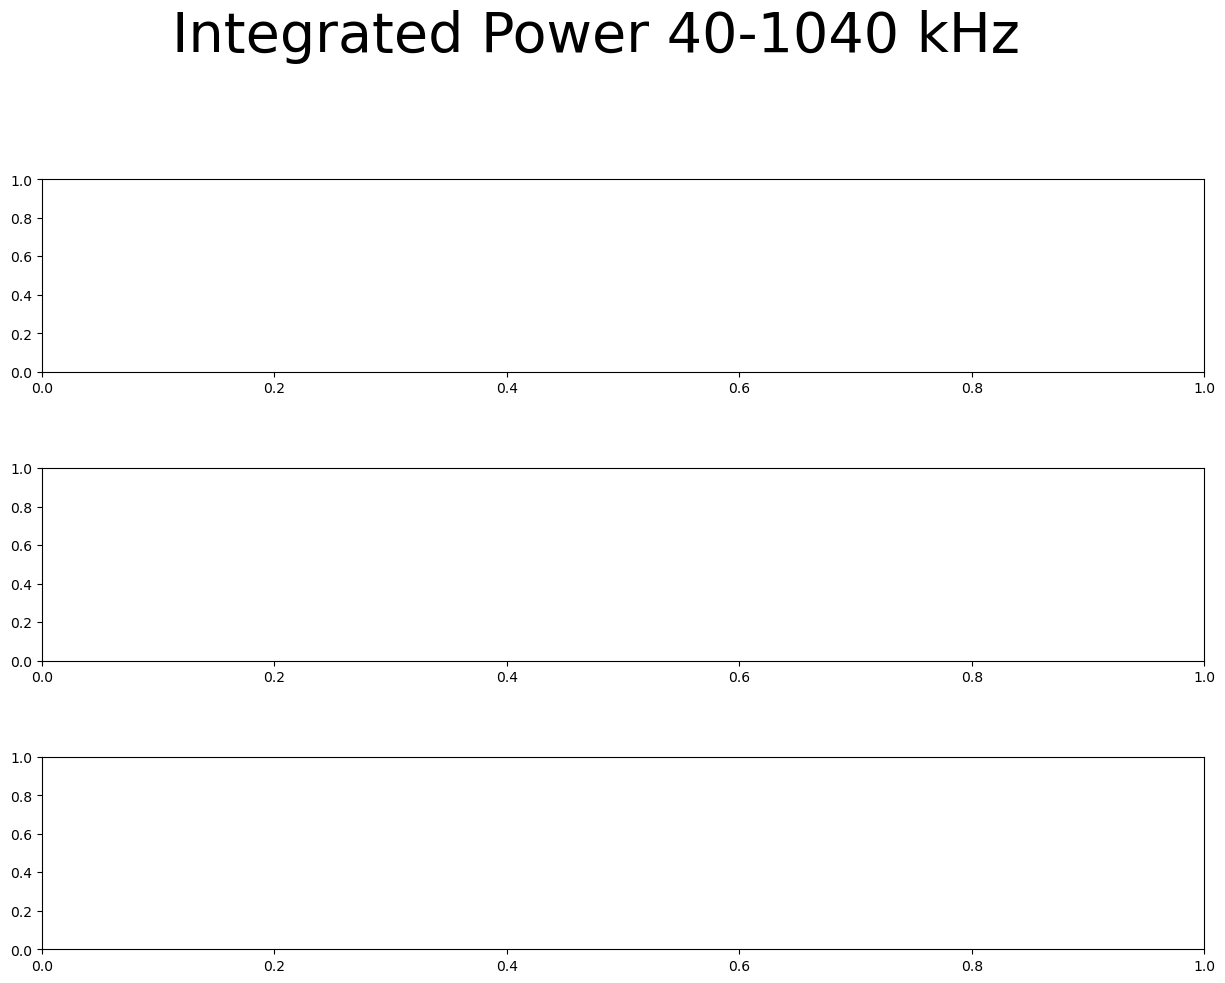

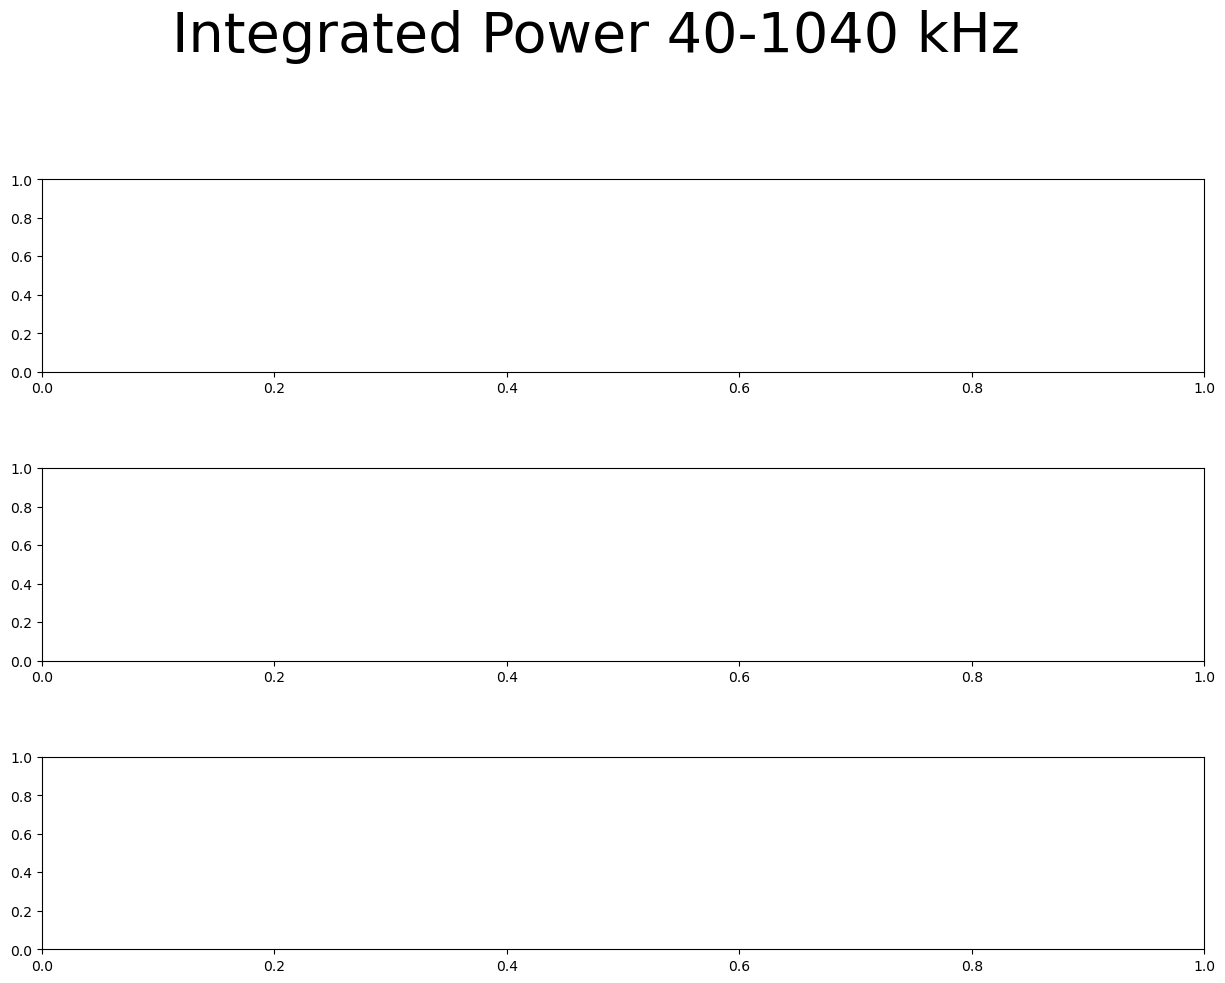

In [32]:
fig=plt.figure(figsize=(15, 10))
fig.suptitle('Integrated Power 40-1040 kHz ', size=40, y=1.05)


gs= fig.add_gridspec(3, 1, hspace=0.5)
ax= fig.add_subplot(gs[0])
ax2= fig.add_subplot(gs[1])
ax3= fig.add_subplot(gs[2])
fig

### Plot for Each Event

100%|██████████| 3/3 [00:00<00:00, 61.74it/s]


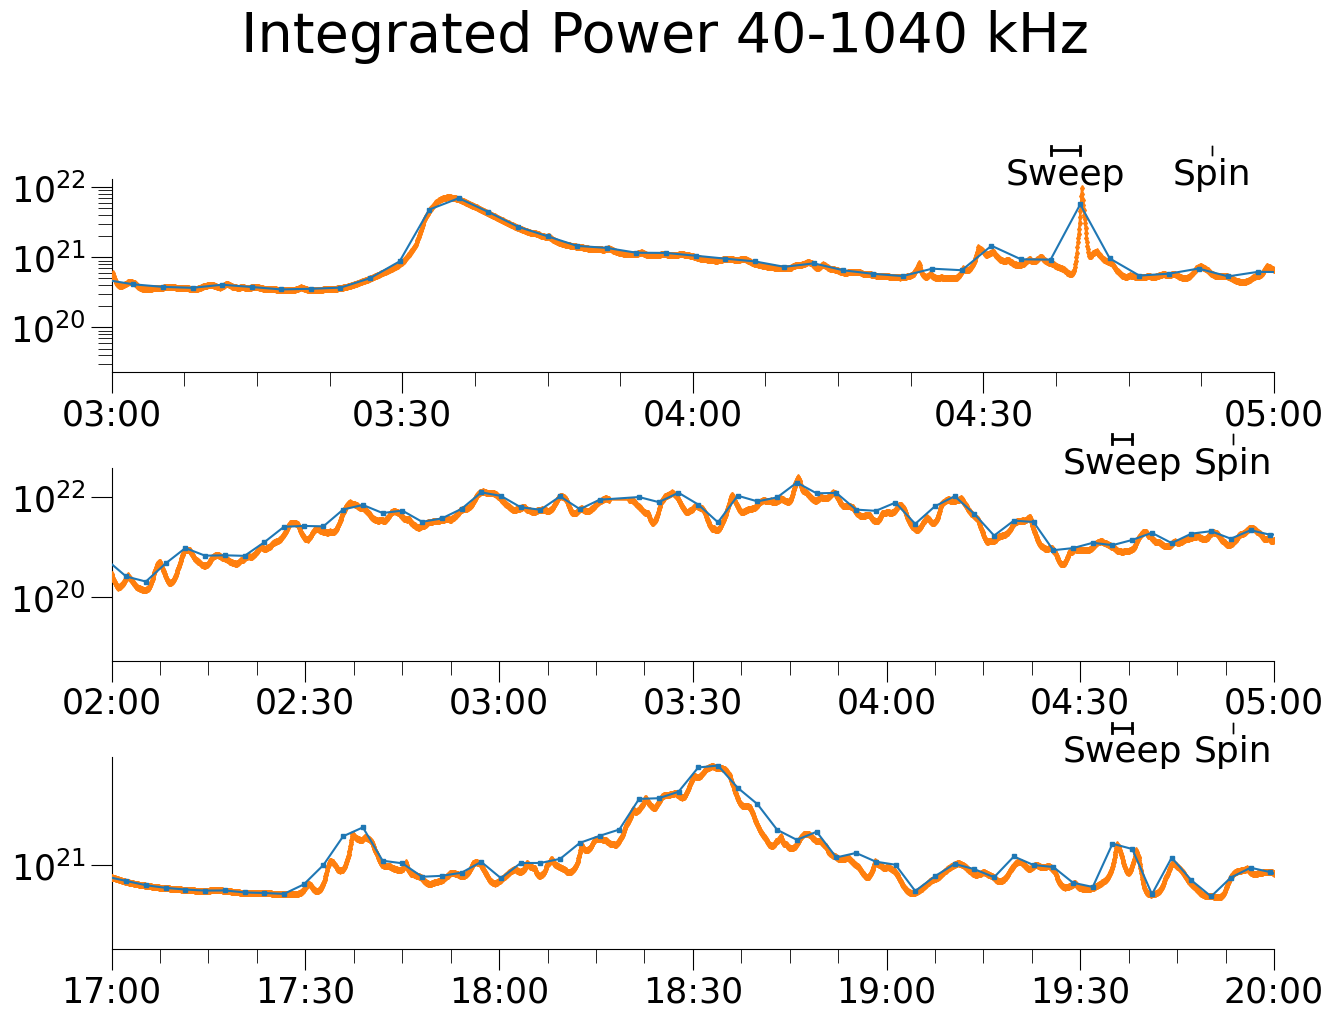

In [33]:
events= [['Solar_Burst', ax, np.datetime64('2004-02-06T03:00'), np.datetime64('2004-02-06T05:00')],
          ['AKR_Burst', ax2, np.datetime64('2001-02-21T02:00'), np.datetime64('2001-02-21T05:00')],
          ['LFEs', ax3, np.datetime64('2001-02-28 17:00'), np.datetime64('2001-02-28 20:00')]]
for name, ax_, start, end in progressbar(events, max_value=len(events)):
    ax_.set_yscale('log')
    ax_.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax_.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))

    int_df= pd.read_csv(f'../../Example_Data/Integrated_Power_{name}_gappy.csv', index_col=0, parse_dates=['Date_UTC'])
    int_df2= pd.read_csv(f'../../Example_Data/Integrated_Power_{name}_filled.csv', index_col=0, parse_dates=['Date_UTC'])


    ax_.plot(int_df.Date_UTC, int_df.integral_40_1040, marker='s',
             label='Sweep Averaged', markersize=3, zorder=100)
    ax_.plot(int_df2.Date_UTC, int_df2.integral_40_1040, marker='d', label='Spin Averaged Gap Filled',
             markersize=3, zorder=10)

    ax_.spines[['top', 'right']].set_visible(False)

    ax_.set_xlim(start, end)

    ax_.minorticks_on()
    ax_.tick_params(axis='both', which='major', labelsize=25, size=15)
    ax_.tick_params(axis='both', which='minor', size=10)
    whisker_width = np.timedelta64(183, 's')  # edit this to change the shown time span

    add_time_whisker(ax_, int_df.iloc[-10].Date_UTC, whisker_width, y_offset=1.15, label='Sweep',
                    lw=2, color='black')
    whisker_width = np.timedelta64(2500, 'ms')  # edit this to change the shown time span

    add_time_whisker(ax_, int_df2.iloc[-200].Date_UTC, whisker_width, y_offset=1.15, label='Spin',
                    lw=1, color='black')
fig

### Add Subplot Labels

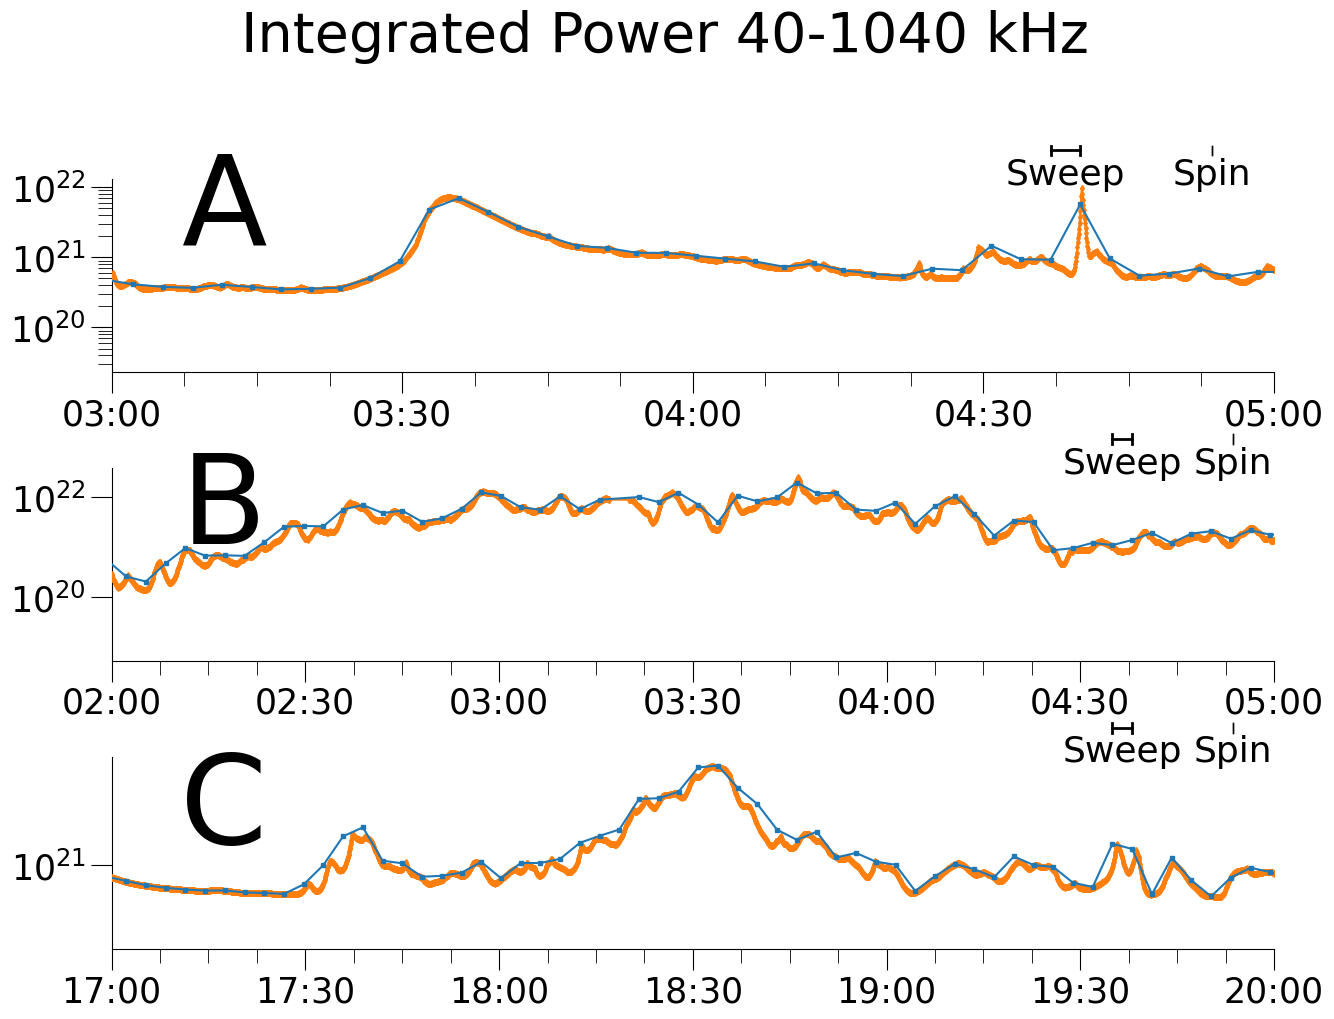

In [34]:
fig.text(.2, .85, 'A', color='black',
         size=90, ha='center', va='center')

fig.text(.2, .55, 'B', color='black',
         size=90, ha='center', va='center')
fig.text(.2, .25, 'C', color='black',
         size=90, ha='center', va='center')
fig

### Format Figure

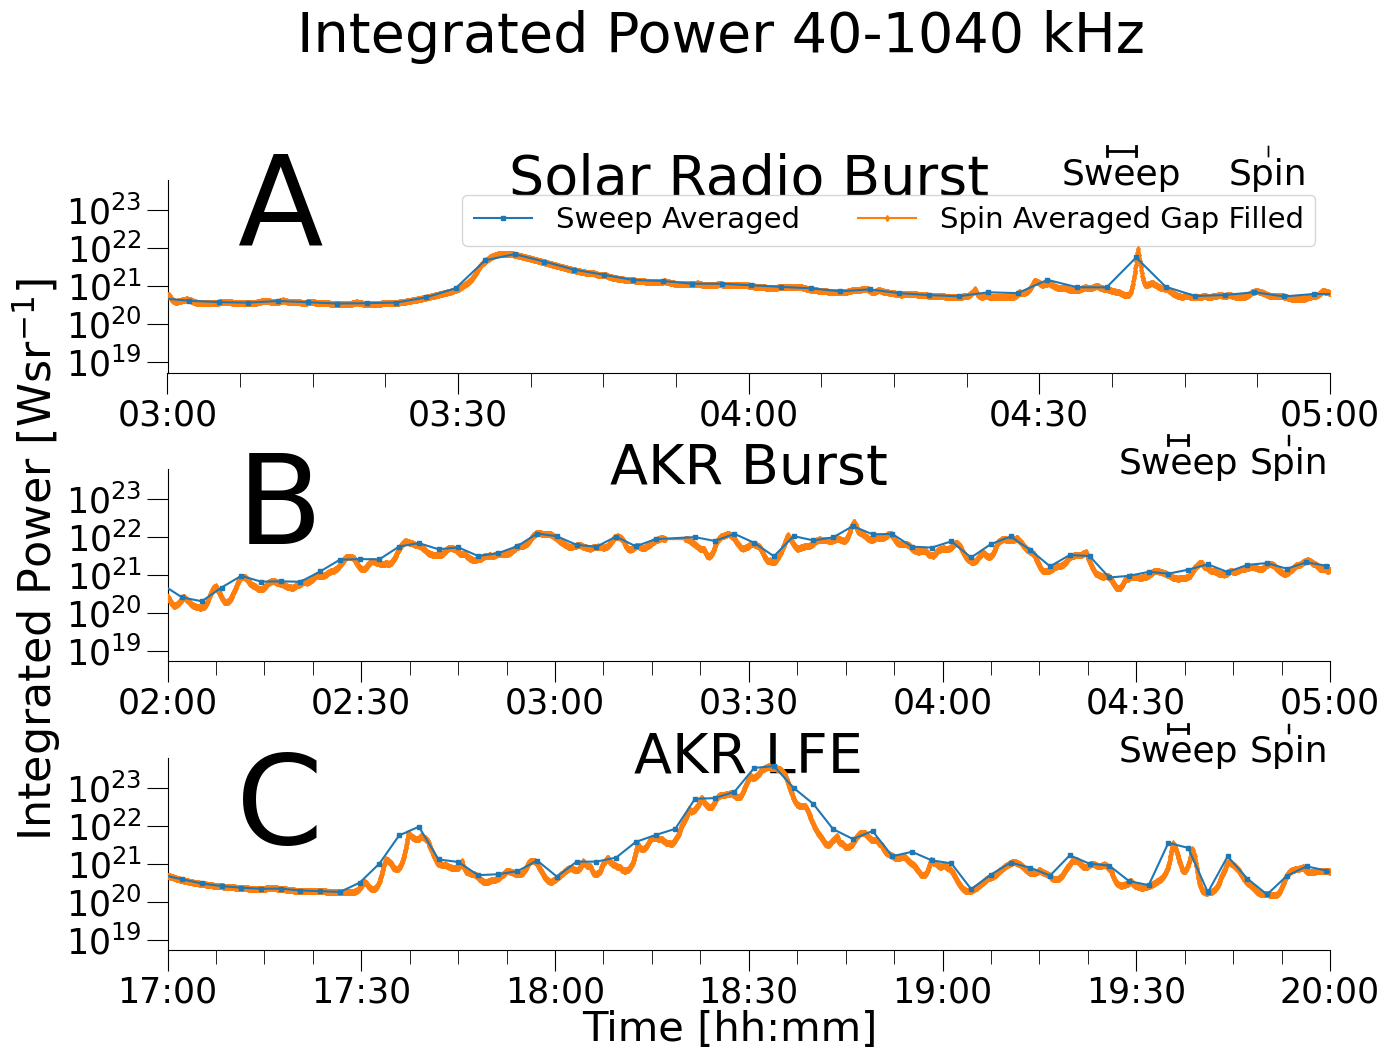

In [ ]:
lims= [ax.get_ylim(), ax2.get_ylim(), ax3.get_ylim()]
ymin= min([lim[0] for lim in lims])
ymax= max([lim[1] for lim in lims])
for ax_ in [ax2, ax3]:
    ax_.sharey(ax)
fig.supylabel('Integrated Power [Wsr$^{-1}$]', size=32)
fig.supxlabel('Time [hh:mm]', size=30)
ax.yaxis.set_major_locator(LogLocator(base=10, numticks=5))
ax.minorticks_on()
ax.set_ylim(ymin, ymax)
ax.set_title('Solar Radio Burst', size=40, y=.88)
ax2.set_title('AKR Burst', size=40, y=.88)
ax3.set_title('AKR LFE', size=40, y=.88)
ax.legend(loc='lower right', fontsize=21, ncols=3)
fig